In [134]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wmfdata as wmf

from wmfdata.utils import (
    pct_str, 
    pd_display_all
)

In [45]:
wmf.charting.set_mpl_style()

The experiment was released to the KaiOS store on 8 April, in version 1.6.0 of the app. On 5 May, we [fixed](https://www.mediawiki.org/w/index.php?title=Wikipedia_for_KaiOS/engagement1&diff=4563366&oldid=4520262) a vandalization of our config that prevent the recommendations from being shown.

In [150]:
PRESTO_PARTITION_DATE = (
    "CONCAT("
        "CAST(year AS VARCHAR), '-', "
        "LPAD(CAST(month AS VARCHAR), 2, '0'), '-', "
        "LPAD(CAST(day AS VARCHAR), 2, '0')"
    ")"
)

user = wmf.presto.run(f"""
WITH pageview AS (
    SELECT
        event.pageview_token AS pageview_id,
        event.session_id AS session_id,
        event.user_id AS user_id,
        MIN(FROM_ISO8601_TIMESTAMP(meta.dt)) AS start_time,
        MAX(
            -- Convert milliseconds to minutes
            CAST(event.page_visible_time AS REAL) / 1000 / 60
        ) AS page_viewing_min,
        -- If any users shift groups or countries, the aggregation
        -- results in an concatenated string, so those users can be identified and excluded
        ARRAY_JOIN(SET_AGG(geocoded_data['country_code']), '-') AS country,
        REDUCE(
            SET_UNION(event.tests), 
            NULL, 
            (i, x) -> IF(
                x.name = '2021-KaiOS-app-homepage-content-suggestions', 
                IF(i IS NULL, x."group", CONCAT(i, '-', x."group")),
                i
            ),
            x -> x
        ) AS experiment_group
    FROM event.inukapageview
    WHERE
        {PRESTO_PARTITION_DATE} >= '2021-05-06'
        AND geocoded_data['country_code'] IN ('NG', 'PK', 'TZ', 'UG')
        AND event.app_version >= '1.6.0'
        AND event.is_production
    GROUP BY
        event.pageview_token,
        event.session_id,
        event.user_id
), session AS (
    SELECT
        session_id,
        user_id,
        MIN(start_time) AS start_time,
        SUM(page_viewing_min) AS page_viewing_min,
        ARRAY_JOIN(SET_AGG(country), '-') AS country,
        ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group
    FROM pageview
    GROUP BY
        user_id,
        session_id
)
SELECT
    user_id,
    MIN(start_time) AS experiment_entry,
    CAST(DATE_DIFF('second', MIN(start_time), CURRENT_TIMESTAMP) AS REAL) / 60 / 60 / 24  AS days_in_experiment,
    COUNT(1) AS sessions,
    AVG(page_viewing_min) AS mean_session_min,
    ARRAY_JOIN(SET_AGG(country), '-') AS country,
    ARRAY_JOIN(SET_AGG(experiment_group), '-') AS experiment_group
FROM session
GROUP BY user_id
""").assign(
    experiment_entry=lambda df: pd.to_datetime(df["experiment_entry"]),
    country=lambda df: df["country"].astype("category"),
    experiment_group=lambda df: df["experiment_group"].astype("category")
)

In [151]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40280 entries, 0 to 40279
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   user_id             40280 non-null  object             
 1   experiment_entry    40280 non-null  datetime64[ns, UTC]
 2   days_in_experiment  40280 non-null  float64            
 3   sessions            40280 non-null  int64              
 4   mean_session_min    40280 non-null  float64            
 5   country             40280 non-null  category           
 6   experiment_group    40280 non-null  category           
dtypes: category(2), datetime64[ns, UTC](1), float64(2), int64(1), object(1)
memory usage: 1.6+ MB


In [ ]:
user.head()

In [ ]:
session.head()

In [50]:
(
    pd
    .pivot_table(session, values="session_id", index="country", columns="experiment_group", aggfunc=len)
    .sort_values('control', ascending=False)
    .head(20)
)

experiment_group,control,trending-articles
country,,
PK,13091,12962
TZ,8963,9174
NG,5985,5585
UG,5140,5479


# Page visible time

In [53]:
session["page_visible_min"].describe()

count     66379.000000
mean         23.422995
std        3445.046123
min      -91119.664000
25%           0.275375
50%           1.066017
75%           3.016633
max      757456.940000
Name: page_visible_min, dtype: float64

In [61]:
with pd.option_context("display.min_rows", 20):
    display(session["page_visible_min"].sort_values(ascending=False))

28793    757456.940000
5921     404880.600000
3315     197977.300000
37038     51575.300000
63891       369.069150
35313       302.811580
16707       283.595400
17603       230.817320
11603       210.945100
37623       197.378560
             ...      
59221         0.000883
66038         0.000883
58030         0.000833
58539         0.000817
49115         0.000817
56734         0.000783
45218         0.000717
6233         -0.396500
29733        -0.675867
45285    -91119.664000
Name: page_visible_min, Length: 66379, dtype: float64

Some sessions have pathological lengths. Let's remove those sessions' users entirely.

In [62]:
pathological_sessions = session.query("page_visible_min < 0 or page_visible_min >= 600")
users_to_drop = pathological_sessions["user_id"].unique()
sessions_to_drop = sessions.query("user_id in @users_to_drop")
session = session.query("session_id not in @sessions_to_drop")
print(f"Dropped {len(sessions_to_drop)} sessions.")

In [66]:
# Proportion of sessions lasting 30 minutes or longer
print(pct_str(session["page_visible_min"][lambda x: x >= 30].pipe(len) / len(session)))

1.8%


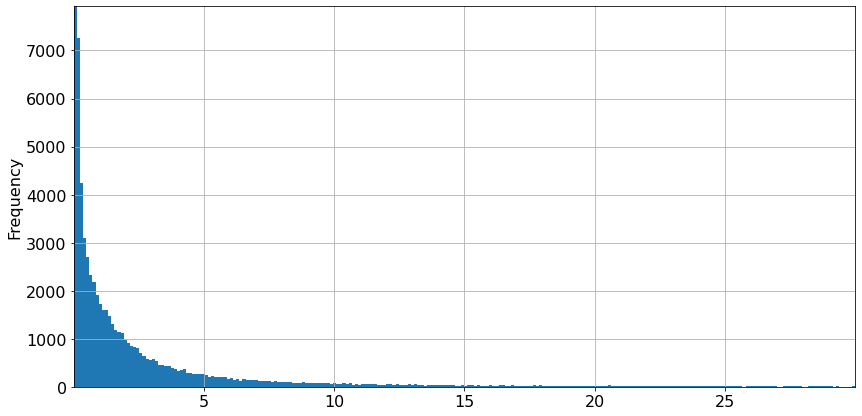

In [67]:
session["page_visible_min"][lambda x: x < 30].plot(kind='hist', bins=250);

In [64]:
session["start_dt"].describe(datetime_is_numeric=True)

count                                  66300
mean     2021-05-30 14:49:48.026987008+00:00
min         2021-05-06 00:00:00.350000+00:00
25%      2021-05-18 14:21:31.488750080+00:00
50%      2021-05-31 04:27:36.006000128+00:00
75%      2021-06-11 15:49:04.591249920+00:00
max         2021-06-22 18:59:51.113000+00:00
Name: start_dt, dtype: object

In [ ]:
session = session.assign(
    time_since_start=lambda df: (df.attrs["creation_time"] - df["start_dt"]).dt.total_seconds() / 60
)

user = session.groupby("user_id").aggregate(
    avg_session_min=pd.NamedAgg(column="page_visible_min", aggfunc="mean"),
    sessions=pd.NamedAgg(column="session_id", aggfunc="count"),
    min_in_experiment=pd.NamedAgg(column="time_since_start", aggfunc="max"),
    country=pd.NamedAgg(column="country", aggfunc="first"),
    experiment_group=pd.NamedAgg(column="experiment_group", aggfunc="first")
).assign(
    lg_min_in_experiment=lambda df: np.log10(df["min_in_experiment"])
)

user.head()

In [74]:
(
    pd
    .pivot_table(user, values="sessions", index="country", columns="experiment_group", aggfunc=len, margins=True)
)

experiment_group,control,trending-articles,All
country,,,
NG,2892,2794,5686
PK,8898,8783,17681
TZ,5346,5297,10643
UG,2702,2686,5388
All,19838,19560,39398


In [75]:
user["min_in_experiment"].describe()

count    39398.000000
mean     35675.554289
std      20365.610058
min        172.796658
25%      17965.647512
50%      35969.652908
75%      53887.725529
max      68984.903758
Name: min_in_experiment, dtype: float64

In [76]:
# Proportion of users with ten sessions or more
print(pct_str(user["sessions"][lambda x: x >= 10].pipe(len) / len(user)))

0.6%


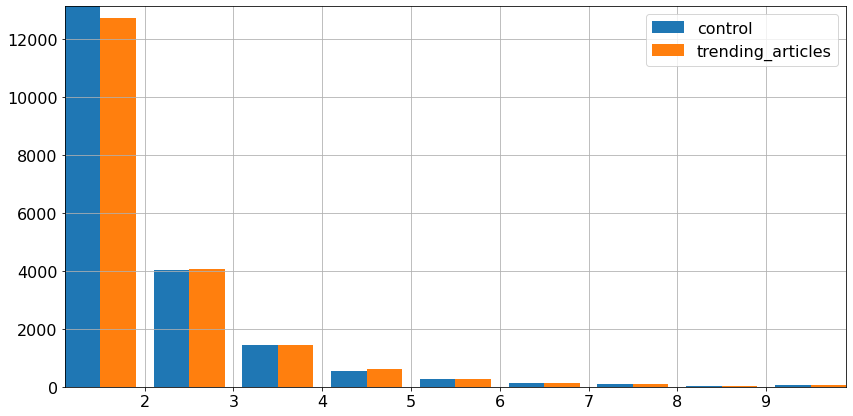

In [89]:
control_session_counts = user.query("experiment_group == 'control'")["sessions"][lambda x: x <= 10]
trending_articles_session_counts = user.query("experiment_group == 'trending-articles'")["sessions"][lambda x: x <= 10]

plt.hist([control_session_counts, trending_articles_session_counts], bins=9, label=["control", "trending_articles"])
plt.legend();

In [91]:
user["avg_session_min"].describe()

count    39398.000000
mean         2.426601
std          4.713506
min          0.001167
25%          0.352550
50%          1.081997
75%          2.553412
max        173.118808
Name: avg_session_min, dtype: float64

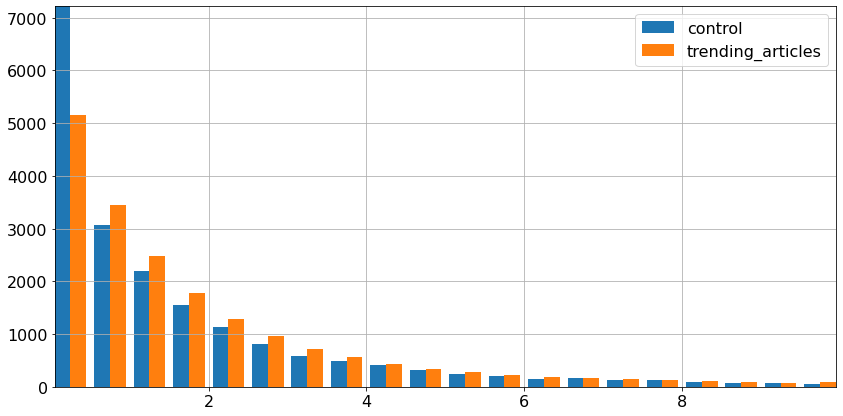

In [92]:
control_session_lengths = user.query("experiment_group == 'control'")["avg_session_min"][lambda x: x <= 10]
trending_articles_session_lengths = user.query("experiment_group == 'trending-articles'")["avg_session_min"][lambda x: x <= 10]

plt.hist([control_session_lengths, trending_articles_session_lengths], bins=20, label=["control", "trending_articles"])
plt.legend();

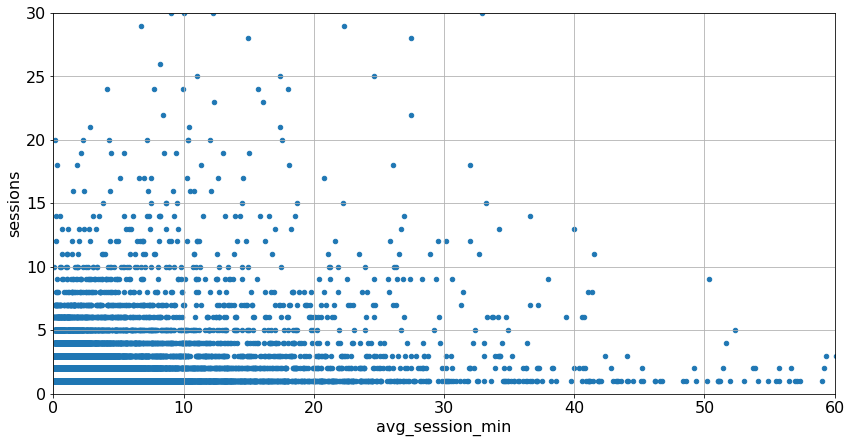

In [93]:
user.plot(
    kind="scatter",
    x="avg_session_min",
    y="sessions",
    xlim=(0, 60),
    ylim=(0, 30)
);

In [94]:
user.corr()

,avg_session_min,sessions,min_in_experiment,lg_min_in_experiment
avg_session_min,1.000000,0.207162,0.028328,0.016446
sessions,0.207162,1.000000,0.121697,0.113578
min_in_experiment,0.028328,0.121697,1.000000,0.887439
lg_min_in_experiment,0.016446,0.113578,0.887439,1.000000


In [95]:
user.to_parquet('data/experiment_user.parquet')

In [96]:
session.to_parquet('data/experiment_session.parquet')